<a href="https://colab.research.google.com/github/MuhammadIrzam447/MultiModel/blob/master/Valid_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import os
from PIL import Image
import torch
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torchvision
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [3]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Loading Validation Dataset and Preprocessing

In [4]:
# save_dir = '/content/Model/Fused_ResNetmodel_Hatefull_Experiment#5'
# load_path = os.path.join(save_dir, 'model.pth')

# # Create an instance of the ResNet model
# resnet = torchvision.models.resnet101(pretrained=False)
# resnet.fc = nn.Linear(2048, 2) # Choose the number of output classses as per your model

# # Load the saved model parameters
# # resnet.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
# resnet.load_state_dict(torch.load(load_path))

# # Set the model to evaluation mode and respective device
# resnet.eval()
# resnet.to(device)

In [5]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.dataset = datasets.ImageFolder(data_dir, transform=val_transform)
        self.classes = sorted(os.listdir(data_dir))
        self.class_lengths = self._compute_class_lengths()

    def _compute_class_lengths(self):
        class_lengths = {cls: 0 for cls in self.classes}

        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            if os.path.isdir(cls_dir):
                class_lengths[cls] = len(os.listdir(cls_dir))

        return class_lengths

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

In [7]:
valPath = "/content/hateful-train+test_unseen/test"
val_dataset = ValidationDataset(valPath)

In [8]:
batch_size = 32
validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
print("Number of samples:", len(val_dataset))
print("Number of classes:", len(val_dataset.classes))

Number of samples: 2000
Number of classes: 2


In [10]:
num_batches = len(validation_data_loader)
print("Number of batches:", num_batches)

Number of batches: 63


# Validation

In [11]:
epoch = 1
save_dir = '/content/Model/Models-Train-03/'
while epoch < 20:
    model_name = str(epoch+1) + "_model.pth"
    load_path = os.path.join(save_dir, model_name)

    # Create an instance of the ResNet model
    resnet = torchvision.models.resnet101(pretrained=False)
    resnet.fc = nn.Linear(2048, 2) # Choose the number of output classses as per your model

    # Load the saved model parameters
    # resnet.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
    resnet.load_state_dict(torch.load(load_path))

    # Set the model to evaluation mode and respective device
    resnet.eval()
    resnet.to(device)

    # resnet.eval()

    predicted_classes = []
    actual_labels = []

    with torch.no_grad():
        for images, labels in validation_data_loader:
            # Move the images and labels to the GPU if available
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = resnet(images)

            # Get the predicted labels
            _, predicted_label = torch.max(outputs, 1)

            # Store the predicted and true labels
            predicted_classes.extend(predicted_label.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

        accuracy = accuracy_score(actual_labels, predicted_classes)
        precision = precision_score(actual_labels, predicted_classes, average='weighted')
        recall = recall_score(actual_labels, predicted_classes, average='weighted')
        f1 = f1_score(actual_labels, predicted_classes, average='weighted')

        print("Result with model " + model_name + " : ")
        print("=========================================")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-score:", f1)
        print(classification_report(actual_labels, predicted_classes))

        predicted_classes = np.array(predicted_classes)
        actual_labels = np.array(actual_labels)

        # Calculate the AUROC score
        auroc = roc_auc_score(actual_labels, predicted_classes)
        print("AUROC:", auroc)
        epoch = epoch + 1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 2_model.pth : 
Accuracy: 0.665
Precision: 0.6526537698412699
Recall: 0.665
F1-score: 0.6525369618888164
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      1250
           1       0.57      0.43      0.49       750

    accuracy                           0.67      2000
   macro avg       0.64      0.62      0.62      2000
weighted avg       0.65      0.67      0.65      2000

AUROC: 0.6173333333333334


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 3_model.pth : 
Accuracy: 0.673
Precision: 0.680874781175986
Recall: 0.673
F1-score: 0.6758735223349723
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1250
           1       0.56      0.62      0.59       750

    accuracy                           0.67      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.68      0.67      0.68      2000

AUROC: 0.6618666666666666


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 4_model.pth : 
Accuracy: 0.697
Precision: 0.7098699605128456
Recall: 0.6970000000000001
F1-score: 0.7006989930893412
              precision    recall  f1-score   support

           0       0.79      0.71      0.74      1250
           1       0.58      0.68      0.63       750

    accuracy                           0.70      2000
   macro avg       0.68      0.69      0.69      2000
weighted avg       0.71      0.70      0.70      2000

AUROC: 0.6936000000000001


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 5_model.pth : 
Accuracy: 0.678
Precision: 0.6904333231614282
Recall: 0.678
F1-score: 0.6818082788671025
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1250
           1       0.56      0.65      0.60       750

    accuracy                           0.68      2000
   macro avg       0.66      0.67      0.67      2000
weighted avg       0.69      0.68      0.68      2000

AUROC: 0.6725333333333332


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 6_model.pth : 
Accuracy: 0.7005
Precision: 0.7114938986151431
Recall: 0.7005
F1-score: 0.7038601426619367
              precision    recall  f1-score   support

           0       0.79      0.72      0.75      1250
           1       0.59      0.67      0.63       750

    accuracy                           0.70      2000
   macro avg       0.69      0.70      0.69      2000
weighted avg       0.71      0.70      0.70      2000

AUROC: 0.6953333333333331


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 7_model.pth : 
Accuracy: 0.7285
Precision: 0.7293211801302182
Recall: 0.7285
F1-score: 0.7288883130778735
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1250
           1       0.64      0.65      0.64       750

    accuracy                           0.73      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.73      0.73      0.73      2000

AUROC: 0.7118666666666666


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 8_model.pth : 
Accuracy: 0.7135
Precision: 0.725984126984127
Recall: 0.7135
F1-score: 0.7169797570850203
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1250
           1       0.60      0.70      0.65       750

    accuracy                           0.71      2000
   macro avg       0.70      0.71      0.70      2000
weighted avg       0.73      0.71      0.72      2000

AUROC: 0.7110666666666666


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 9_model.pth : 
Accuracy: 0.7275
Precision: 0.7250925208498841
Recall: 0.7275
F1-score: 0.7260412605671199
              precision    recall  f1-score   support

           0       0.77      0.80      0.79      1250
           1       0.64      0.61      0.63       750

    accuracy                           0.73      2000
   macro avg       0.71      0.70      0.71      2000
weighted avg       0.73      0.73      0.73      2000

AUROC: 0.7044


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 10_model.pth : 
Accuracy: 0.712
Precision: 0.7226948184414526
Recall: 0.712
F1-score: 0.7152108942540086
              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1250
           1       0.60      0.69      0.64       750

    accuracy                           0.71      2000
   macro avg       0.70      0.71      0.70      2000
weighted avg       0.72      0.71      0.72      2000

AUROC: 0.7074666666666667


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 11_model.pth : 
Accuracy: 0.694
Precision: 0.714734382972227
Recall: 0.694
F1-score: 0.6985618992529508
              precision    recall  f1-score   support

           0       0.80      0.68      0.74      1250
           1       0.57      0.71      0.64       750

    accuracy                           0.69      2000
   macro avg       0.69      0.70      0.69      2000
weighted avg       0.71      0.69      0.70      2000

AUROC: 0.6981333333333333


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 12_model.pth : 
Accuracy: 0.6835
Precision: 0.708402855743586
Recall: 0.6835
F1-score: 0.6884278582880183
              precision    recall  f1-score   support

           0       0.80      0.66      0.72      1250
           1       0.56      0.72      0.63       750

    accuracy                           0.68      2000
   macro avg       0.68      0.69      0.68      2000
weighted avg       0.71      0.68      0.69      2000

AUROC: 0.6905333333333332


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 13_model.pth : 
Accuracy: 0.7295
Precision: 0.7292854578729923
Recall: 0.7295
F1-score: 0.7293910633892635
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1250
           1       0.64      0.64      0.64       750

    accuracy                           0.73      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.73      0.73      0.73      2000

AUROC: 0.7110666666666666


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 14_model.pth : 
Accuracy: 0.7145
Precision: 0.7210589302250197
Recall: 0.7145
F1-score: 0.71683108628271
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1250
           1       0.61      0.67      0.64       750

    accuracy                           0.71      2000
   macro avg       0.70      0.71      0.70      2000
weighted avg       0.72      0.71      0.72      2000

AUROC: 0.7051999999999999


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 15_model.pth : 
Accuracy: 0.7195
Precision: 0.7268296053586484
Recall: 0.7195
F1-score: 0.7219892250863459
              precision    recall  f1-score   support

           0       0.79      0.74      0.77      1250
           1       0.61      0.68      0.65       750

    accuracy                           0.72      2000
   macro avg       0.70      0.71      0.71      2000
weighted avg       0.73      0.72      0.72      2000

AUROC: 0.7116000000000002


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 16_model.pth : 
Accuracy: 0.7215
Precision: 0.7250557905701398
Recall: 0.7215
F1-score: 0.7229435730731907
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1250
           1       0.62      0.66      0.64       750

    accuracy                           0.72      2000
   macro avg       0.70      0.71      0.71      2000
weighted avg       0.73      0.72      0.72      2000

AUROC: 0.7086666666666667


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 17_model.pth : 
Accuracy: 0.6915
Precision: 0.7104060189643566
Recall: 0.6915
F1-score: 0.6959596547473778
              precision    recall  f1-score   support

           0       0.79      0.68      0.74      1250
           1       0.57      0.70      0.63       750

    accuracy                           0.69      2000
   macro avg       0.68      0.69      0.68      2000
weighted avg       0.71      0.69      0.70      2000

AUROC: 0.6937333333333334


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 18_model.pth : 
Accuracy: 0.718
Precision: 0.7265444557944527
Recall: 0.718
F1-score: 0.7207611980166614
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1250
           1       0.61      0.69      0.65       750

    accuracy                           0.72      2000
   macro avg       0.70      0.71      0.71      2000
weighted avg       0.73      0.72      0.72      2000

AUROC: 0.7114666666666667


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 19_model.pth : 
Accuracy: 0.7145
Precision: 0.7202421630296912
Recall: 0.7145
F1-score: 0.716618338789354
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1250
           1       0.61      0.66      0.64       750

    accuracy                           0.71      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.72      0.71      0.72      2000

AUROC: 0.7041333333333333


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Result with model 20_model.pth : 
Accuracy: 0.7115
Precision: 0.7191569429828487
Recall: 0.7115
F1-score: 0.7141097709920073
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1250
           1       0.60      0.67      0.64       750

    accuracy                           0.71      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.72      0.71      0.71      2000

AUROC: 0.7033333333333334


In [12]:
accuracy = accuracy_score(actual_labels, predicted_classes)
precision = precision_score(actual_labels, predicted_classes, average='weighted')
recall = recall_score(actual_labels, predicted_classes, average='weighted')
f1 = f1_score(actual_labels, predicted_classes, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7115
Precision: 0.7191569429828487
Recall: 0.7115
F1-score: 0.7141097709920073


In [13]:
print(classification_report(actual_labels, predicted_classes))

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1250
           1       0.60      0.67      0.64       750

    accuracy                           0.71      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.72      0.71      0.71      2000



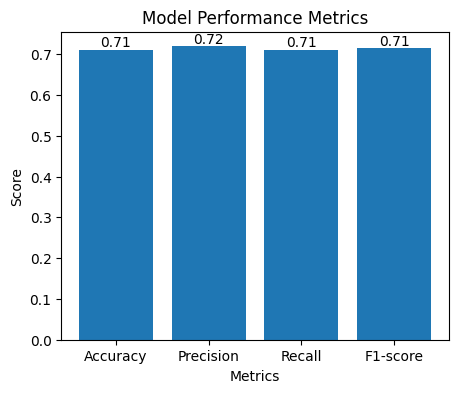

In [14]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(x, values)

# labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# scores on top of each bar
for i, bar in enumerate(bars):
    score = values[i]
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{score:.2f}', ha='center', va='bottom')

plt.show()

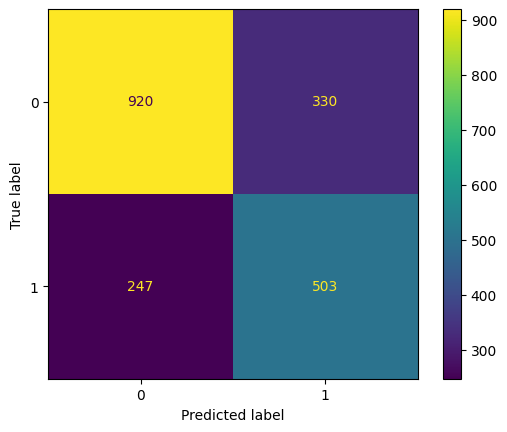

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(actual_labels, predicted_classes)
ConfusionMatrixDisplay(cm).plot()

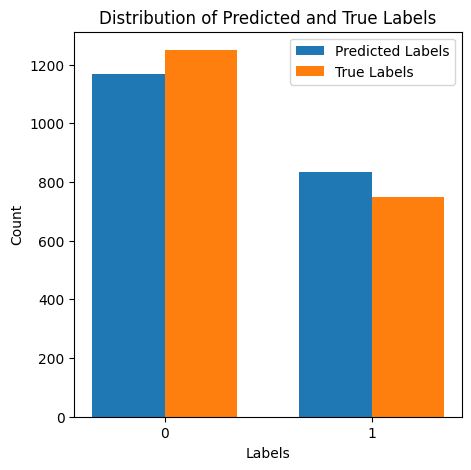

In [16]:
# Count the occurrences of each label in predicted and true labels
predicted_counts = np.bincount(predicted_classes)
true_counts = np.bincount(actual_labels)

# Get the unique labels
labels = np.unique(np.concatenate((predicted_classes, actual_labels)))

# Set the x-axis range
x = np.arange(len(labels))

# Set the width of the bars
width = 0.35

# Plot the predicted and true label counts
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(x - width/2, predicted_counts, width, label='Predicted Labels')
ax.bar(x + width/2, true_counts, width, label='True Labels')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Predicted and True Labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()